In [31]:
# Import des libraries

import sys
sys.path.insert(0, '../src/')

import time
import numpy as np
import pandas as pd
import xgboost as xgb 

# Importing libraries - sklearn
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle       # for saving/loading train-test sets

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import auto_co2 as co2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [33]:
%%time
# file_path = "../data/sample/co2_regression_sample.csv"
# pour test
file_path = "../data/sample/regr_1000.csv"

df = pd.read_csv(file_path)

y = df['Co2EmissionsWltp']
X = df.drop(columns='Co2EmissionsWltp')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=100)

scaler = preprocessing.StandardScaler()
X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

CPU times: total: 0 ns
Wall time: 18 ms


In [34]:
import plotly.graph_objects as go
import numpy as np
from scipy.stats import gaussian_kde

def plot_continuous_distribution(s, title='', interactive=True):
    # Calculate the Kernel Density Estimation of the series
    x = np.linspace(s.min(), s.max(), 1000)
    kde = gaussian_kde(s)
    y = kde.evaluate(x)

    # Create the line plot for the KDE
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name='KDE', yaxis='y2'))

    # Add a histogram
    fig.add_trace(go.Histogram(x=s, nbinsx=40, name='Histogram'))

    # Add title and labels
    fig.update_layout(
        title={
            'text': f'Courbe KDE de {title}',
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(
                size=20
            )
        },
        xaxis_title=s.name,
        yaxis_title='Count',
        yaxis2=dict(
            title='Density',
            overlaying='y',
            side='right'
        ),
        barmode='overlay'
    )

    # Make the histogram semi-transparent
    fig.data[1].marker.line.width = 1
    fig.data[1].marker.line.color = "black"
    fig.data[1].opacity = 0.5

    if interactive:
        fig.show()
    else:
        img_bytes = pio.to_image(fig, format='png')
        display(Image(img_bytes))
plot_continuous_distribution(y)

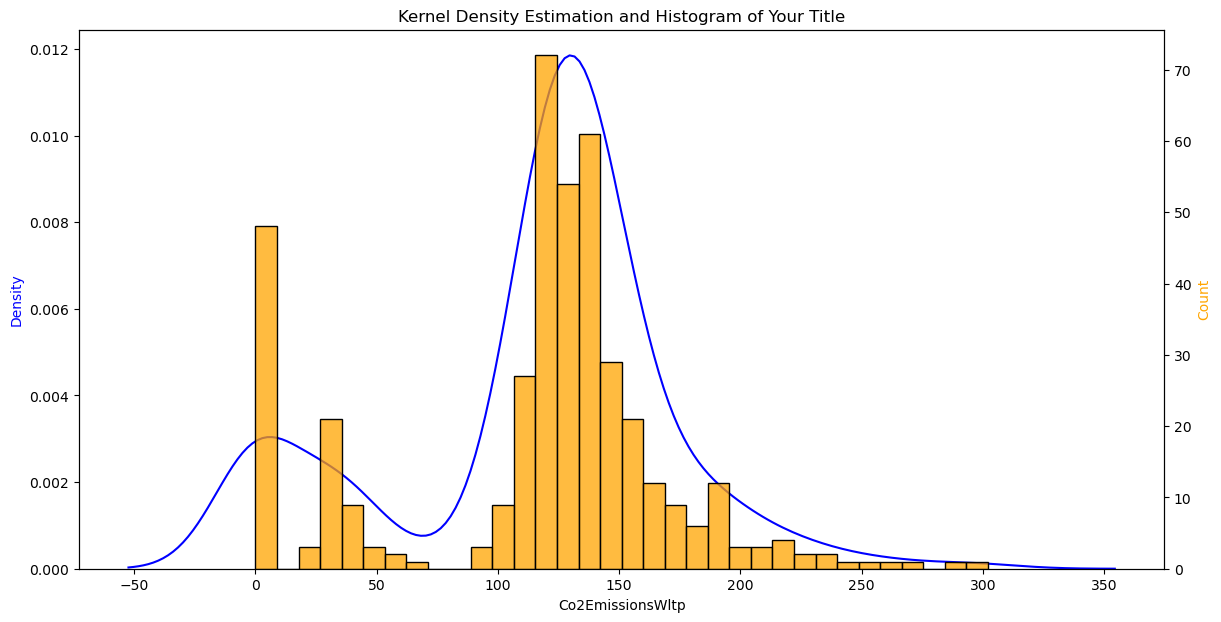

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_continuous_distribution_seaborn(s, title=''):
    # Create a new matplotlib figure
    fig, ax1 = plt.subplots()

    # Create the KDE plot on the first axis
    sns.kdeplot(s, ax=ax1, color='blue')

    # Create a second axis for the histogram
    ax2 = ax1.twinx()
    sns.histplot(s, ax=ax2, color='orange', kde=False)

    # Set the title and labels
    ax1.set_title(f'Kernel Density Estimation and Histogram of {title}')
    ax1.set_xlabel(s.name)
    ax1.set_ylabel('Density', color='blue')
    ax2.set_ylabel('Count', color='orange')

    plt.show()

# Use the function
plot_continuous_distribution_seaborn(y, title='Your Title')

In [36]:
# model configuration ant training
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

pred = lr1.predict(X_train)
pred_test = lr1.predict(X_test)

In [37]:
co2.styles.display_combined_report(y_train, pred, y_test, pred_test, title='PERFORMANCES DU MODELE DE REGRESSION LINEAIRE')
co2.styles.displayer(pd.DataFrame({'Co2 Observé': y_test, 'Co2 prédit': pred_test},
             index=X_test.index), n=10, title='REGRESSION LINEAIRE: COMPARAISON DE QUELQUES VALEURS')

co2.viz.plot_regression_diagnostics(y_test, pred_test, y_train, "Régression linéaire simple", interactive=True, save=True, format='png')

,Train Set,Test Set
Mean Squared Error,188.629,293.501
Root Mean Squared Error,13.734,17.132
Mean Absolute Error,10.372,10.732
R2 Score,0.945,0.912


<class 'pandas.io.formats.style.Styler'>


,Co2 Observé,Co2 prédit
136,137.000,140.531
269,153.000,153.478
300,0.000,-8.812
152,168.000,166.646
23,0.000,-5.811
56,123.000,117.540
315,190.000,206.747
125,117.000,113.212
198,177.000,176.474
43,128.000,128.507


<class 'pandas.io.formats.style.Styler'>


In [38]:
%%time
l1_ratios = [0.05, 0.1, 0.2, 0.5, 0.6, 1]
lr_en = ElasticNetCV(cv=5, l1_ratio=l1_ratios, alphas=[0.1, 0.5, 0.9, 0.95, 1.0], n_jobs=-1)
lr_en.fit(X_train, y_train)

CPU times: total: 500 ms
Wall time: 110 ms


ElasticNetCV(alphas=[0.1, 0.5, 0.9, 0.95, 1.0], cv=5,
             l1_ratio=[0.05, 0.1, 0.2, 0.5, 0.6, 1], n_jobs=-1)

In [39]:
co2.styles.display_combined_report(y_train, lr_en.predict(X_train), y_test, lr_en.predict(X_test), title='PERFORMANCES DU MODELE ELASTIC NET') 

co2.viz.plot_regression_diagnostics(y_test, pred_test, y_train, "ElasticNet", interactive=True, save=True, format='png')
co2.viz.plot_lr_elasticnet(lr_en, save=True, format='png')
co2.viz.plot_mse_folds(lr_en, l1_ratios)

,Train Set,Test Set
Mean Squared Error,188.889,306.675
Root Mean Squared Error,13.744,17.512
Mean Absolute Error,10.382,10.709
R2 Score,0.945,0.908


<class 'pandas.io.formats.style.Styler'>


In [40]:
%%time

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 3)

train = xgb.DMatrix(data = X_train, label = y_train)
test = xgb.DMatrix(data = X_test, label = y_test)
valid = xgb.DMatrix(data = X_valid, label = y_valid)

params = {'booster' : 'gbtree', 'learning_rate' : 1, 'objective' : 'reg:linear'}
model = xgb.train(params=params, dtrain = train, num_boost_round = 10, early_stopping_rounds = 15, evals= [(train, 'train'), (test, 'valid')] )
# préferer  'learning_rate' << 1 → 0,01  et num_boost_round grand = 700,

pred_test = model.predict(test)
pred_train = model.predict(train)

[0]	train-rmse:11.26501	valid-rmse:19.75068
[1]	train-rmse:7.64098	valid-rmse:14.40195
[2]	train-rmse:6.01461	valid-rmse:14.13725
[3]	train-rmse:5.45879	valid-rmse:14.67708
[4]	train-rmse:4.53750	valid-rmse:15.30235
[5]	train-rmse:3.35563	valid-rmse:15.30734
[6]	train-rmse:3.01521	valid-rmse:15.26796
[7]	train-rmse:2.61440	valid-rmse:15.37373
[8]	train-rmse:2.21508	valid-rmse:15.48109
[9]	train-rmse:1.75225	valid-rmse:15.29885


CPU times: total: 250 ms
Wall time: 43 ms


[07:20:24] WARNING: D:\bld\xgboost-split_1703077804448\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
co2.styles.display_combined_report(y_train, pred_train, y_test, pred_test, title='PERFORMANCES DU MODELE XGBOOST') 

co2.viz.plot_regression_diagnostics(y_test, pred_test, y_train, "Régression linéaire simple", interactive=True, save=True, format='png')

,Train Set,Test Set
Mean Squared Error,3.070,234.055
Root Mean Squared Error,1.752,15.299
Mean Absolute Error,1.233,8.957
R2 Score,0.999,0.923


<class 'pandas.io.formats.style.Styler'>


# **4. Interprétabilité du modèle XGB Linear Regressor**

[07:20:34] WARNING: D:\bld\xgboost-split_1703077804448\work\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


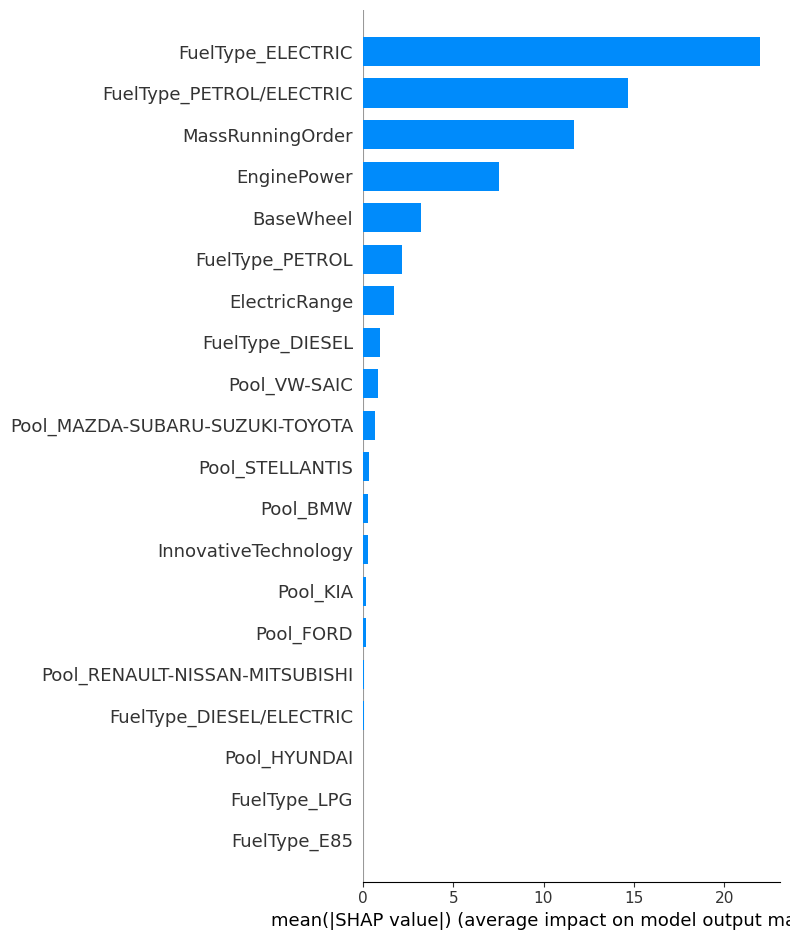

In [42]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [43]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(X_train, feature_names=X_train.columns)

def predict_xg(x):
    return pd.DataFrame(model.predict(xgb.DMatrix(x)))

model_1 = InMemoryModel(predict_xg, examples = X_train)

In [44]:
plt.rcParams['figure.figsize'] = (14,7)

plots = interpreter.feature_importance.plot_feature_importance(
    model_1, ascending=True)

[6/22] features █████--------------- Time elapsed: 0 seconds

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

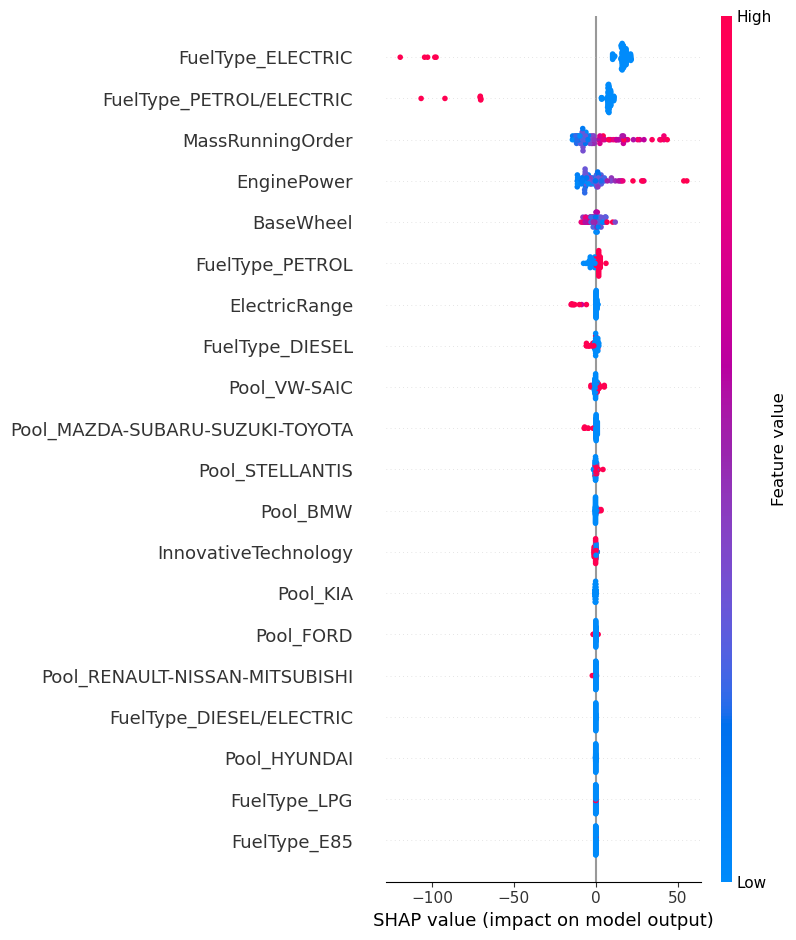

In [45]:
shap.summary_plot(shap_values, X_test)

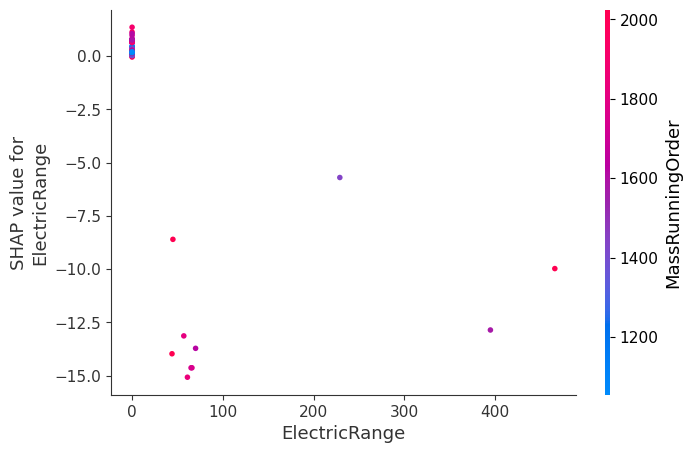

In [46]:
shap.dependence_plot("ElectricRange", shap_values, X_test, interaction_index= "MassRunningOrder")

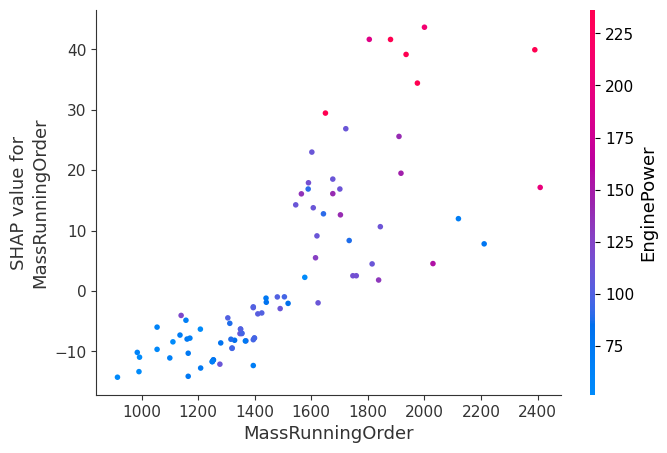

In [47]:
shap.dependence_plot("MassRunningOrder", shap_values, X_test, interaction_index= "EnginePower")

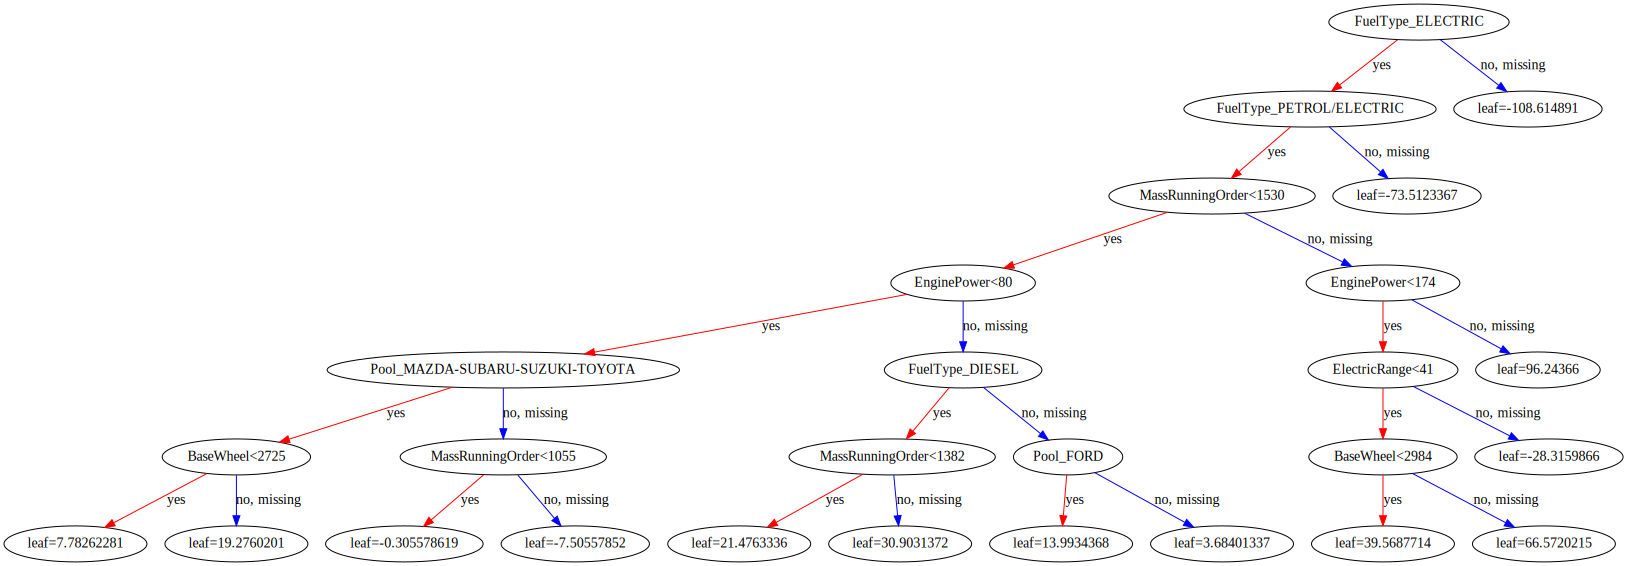

In [49]:
import graphviz
xgb.to_graphviz(model, num_trees=0)

In [ ]:
# Récupération des prédictions

# pred_test = model.predict(test)
# pred_train = model.predict(train)

#Entraînement du modèle
sg_clf = LinearRegression()
sg_clf.fit(X_train, pred_train)

# Scores du modèle
sg_clf.score(X_test, y_test)
# print(classification_report(y_test, sg_clf.predict(X_test)))

# #Comparaison des prédictions
# print(sum(preds!=sg_clf.predict(X_train)))

# # Comparaison des prédictions sur le jeu de test
# probs = bst.predict(dtest)
# preds = [0 if x<0.5 else 1 for x in probs]